# N-Grams

N-Grams are groups of tokens. Up to now we've been using unigram (1-gram) words. Bigram and Trigram words are popular, especially in more complex documents.

The code below is the same as previous. You might need to copy your code from the previous notebook if you altered it.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def balanced_spl_by(df, lblcol, uspl=True):
    np.random.seed(42)
    datas_l = [ df[df[lblcol]==l].copy() for l in list(set(df[lblcol].values)) ]
    lsz = [f.shape[0] for f in datas_l ]
    return pd.concat([f.sample(n = (min(lsz) if uspl else max(lsz)), replace = (not uspl)).copy() for f in datas_l ], axis=0 ).sample(frac=1)

trolls = pd.read_csv("data/trolls.csv")
trolls = balanced_spl_by(trolls, "Insult")
X, y = (trolls["Comment"], trolls["Insult"])

In [3]:
def clean(X):
    # Lowercase everything
    X = X.str.lower()
    
    # Get rid of those duplicate backslashes
    X = X.str.replace(r'\\\\', r'\\', case=False)
    
    # Remove whitespace
    X = X.str.replace('"', ' ')
    X = X.str.replace('_', ' ')
    X = X.str.replace('-', ' ')
    X = X.str.replace(r'\n', ' ')
    X = X.str.replace(r'\\n', ' ')
    X = X.str.replace(r'\t', ' ')
    X = X.str.replace(r'\\t', ' ')
    X = X.str.replace(r"\\xa0", ' ') # A space
    X = X.str.replace(r"\\xc2", ' ') # A space
    X = X.str.replace(' +', ' ')
    
    # Ditch all other unicode
    X = X.str.decode("unicode_escape").str.encode('ascii', 'ignore').str.decode("utf-8")
    
    # Remove contractions
    X = X.str.replace("won't", "will not")
    X = X.str.replace("can't", "can not")
    X = X.str.replace("don't", "do not")
    X = X.str.replace("i'm", "i am")
    X = X.str.replace(" im", " i am")
    X = X.str.replace("ain't", "is not")
    X = X.str.replace("'ll", " will")
    X = X.str.replace("'t", " not")
    X = X.str.replace("'ve", " have")
    X = X.str.replace("'re", " are")
    X = X.str.replace("'d", " would")
    
    # Create tokens of interest
    X = X.str.replace(r"([#%&\*\$]{2,})(\w*)", r"_SW") # Swearword obfuscations
    X = X.str.replace(r" [8x;:=]-?(?:\)|\}|\]|>){2,}", " _BS") # Big smileys
    X = X.str.replace(r" (?:[;:=]-?[\)\}\]d>])|(?:<3)", " _S") # Smileys   
    X = X.str.replace(r" [x:=]-?[\(\[\|\\/\{<]', r", " _F") # Sad faces
    X = X.str.replace(r" [x:=]-?(?:\(|\[|\||\\|/|\{|<){2,}", " _BF") # Big Sad faces   
    X = X.str.replace(r"(@[a-z]+)", r"_AT") # Directed at someone
    X = X.str.replace(r"[\w\-][\w\-\.]+@[\w\-][\w\-\.]+[a-zA-Z]{1,4}", r"_EM") # Email
    X = X.str.replace(r"\w+:\/\/\S+", r"_U") # URL
    
    return X

X = clean(X)

def stemming(X):
    X = X.str.replace("ies( |$|\.)", "y ")  # Plurals
    X = X.str.replace("(?<!i)s( |$|\.)", " ")  # Plurals
    X = X.str.replace("ing( |$|\.)", " ")  # adverbs
    X = X.str.replace("ed( |$|\.)", " ")  # Past tense
    X = X.str.replace("your( |$|\.)", "you ") # Personal
    X = X.str.replace("our( |$|\.)", "us ") # Personal
    return X

X = stemming(X)

def stopwords(X):
    X = X.str.replace("the( |$)", " ")
    X = X.str.replace("and( |$)", " ")
    X = X.str.replace("but( |$)", " ")
    X = X.str.replace("of( |$)", " ")
    X = X.str.replace("on( |$)", " ")
    return X

X = stopwords(X)

def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display_markdown
    df = df.round(2)
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return ((df_formatted.to_csv(sep="|", index=False)))

## CountVectorizer

The count vectorizer can produce n-grams. We do this first just to show you the words that are created. You select the number of n-grams by altering the tuple.

### Tasks

- Try chaning the n-gram settings

In [4]:
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(X[8:10])
print(X_train_counts.shape)
print(count_vect.get_feature_names())

(2, 115)
['_at', '_at _at', '_at yo', 'aburrido', 'aburrido nose', 'are', 'are fuck', 'as', 'as btw', 'borderstate', 'borderstate mexico', 'both', 'both you', 'btw', 'btw most', 'cambio', 'cambio de', 'cause', 'cause both', 'check', 'check oaxaca', 'de', 'de tema', 'did', 'did you', 'el', 'el lol', 'forget', 'forget that', 'fuck', 'fuck troll', 'have', 'have you', 'head', 'head up', 'intalado', 'intalado me', 'is', 'is borderstate', 'is relatively', 'juegan', 'juegan tanto', 'know', 'know that', 'last', 'last time', 'lo', 'lo juegan', 'lol', 'lol intalado', 'me', 'me parece', 'mexico', 'mexico or', 'most', 'most violence', 'nose', 'nose porque', 'not', 'not know', 'oaxaca', 'oaxaca is', 'or', 'or did', 'parece', 'parece tan', 'perd', 'porque', 'porque lo', 'relatively', 'relatively safe', 'safe', 'safe ya', 'sicken', 'sicken thought', 'tan', 'tan aburrido', 'tanto', 'tanto cambio', 'tema', 'tema perd', 'tengo', 'tengo el', 'that', 'that cause', 'that too', 'thought', 'thought last', 't

## TFIDF N-Grams

The TFIDF algorithm takse the same settings. Let's see how a number of n-grams alters performance.

0.740177504694
0.732430875576
0.742554190135


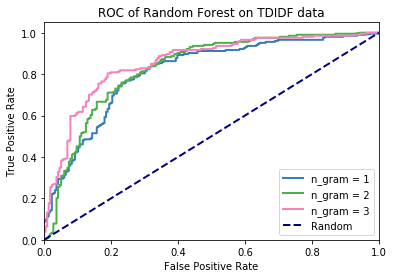

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

plt.figure();
colours = np.array(['#ff7f00','#377eb8','#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00'])

for n in range(1, 4):
    tfidf_vect = TfidfVectorizer(analyzer = "word", tokenizer=None, preprocessor=None, \
                                 stop_words=None, max_features=500, ngram_range=(1, n))
    X_train_counts = tfidf_vect.fit_transform(X_train)
    X_test_counts = tfidf_vect.transform(X_test)

    clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=50, random_state=42)
    clf.fit(X_train_counts, y_train)
    scores = cross_val_score(clf, X_train_counts, y_train)
    scores.mean()           
    print(scores.mean())

    y_proba = clf.predict_proba(X_test_counts)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])

    lw = 2
    plt.plot(fpr, tpr, color=colours[n],
             lw=lw, label='n_gram = %d' % n)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest on TDIDF data')
plt.legend(loc="lower right")
plt.show()

It's interesting to note that the higher n-grams to better at low false-positive rates, but then tail off near the top. I certainly think that the higher-ngrams are better, but these aren't represented properly in the accuracy scores. AUC or F1-Score would better represent performance.

## Tasks

- Maybe we're not getting very good n-gram performance because our model can't handle it. Try another model?